# P53 - DMS Analyse
#### by Frido Petersen, Dario Prifti, Maximilian Fidlin and Enno Schäfer
*With special thanks to our Co-Worker, inspiration and beloved friend: Chat-GPT*

In [12]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import seaborn as sns
import data_exploration as de
import data_cleanup as dc
import functions as fun
import Documentation as doc
import severity_score as ses
import scipy.stats as stats
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import AgglomerativeClustering

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# These are all the datasets we used
gia_null_eto: pd.DataFrame = pd.read_csv('../DMS_data/P53_HUMAN_Giacomelli_NULL_Etoposide_2018.csv')
gia_null_nut: pd.DataFrame = pd.read_csv('../DMS_data/P53_HUMAN_Giacomelli_NULL_Nutlin_2018.csv')
gia_wt_nut: pd.DataFrame = pd.read_csv('../DMS_data/P53_HUMAN_Giacomelli_WT_Nutlin_2018.csv')
kot_hum: pd.DataFrame = pd.read_csv('../DMS_data/P53_HUMAN_Kotler_2018.csv')

aa = pd.read_csv('../DMS_data/aminoacids.csv')

## Grobe Struktur:
1) Data Cleanup: wir hatten diese Daten, das und das haben wir damit gemacht, so und so sehen unsere Daten jetzt aus
    (i) NA - remove
    (ii) Z - Transformierung
    (iii) Normalisierung
` `
` `
2) Data Exploration
    (i) Distanzmatrix
    (ii) Clustering
    (iii) weitere Clustering-Methoden
    (iv) Zusätzliche AS Daten
` `
` `
3) T-tests

## Comparibility of p53 Datasets
#### Finding similarities and differences in the 4 datasets on p53

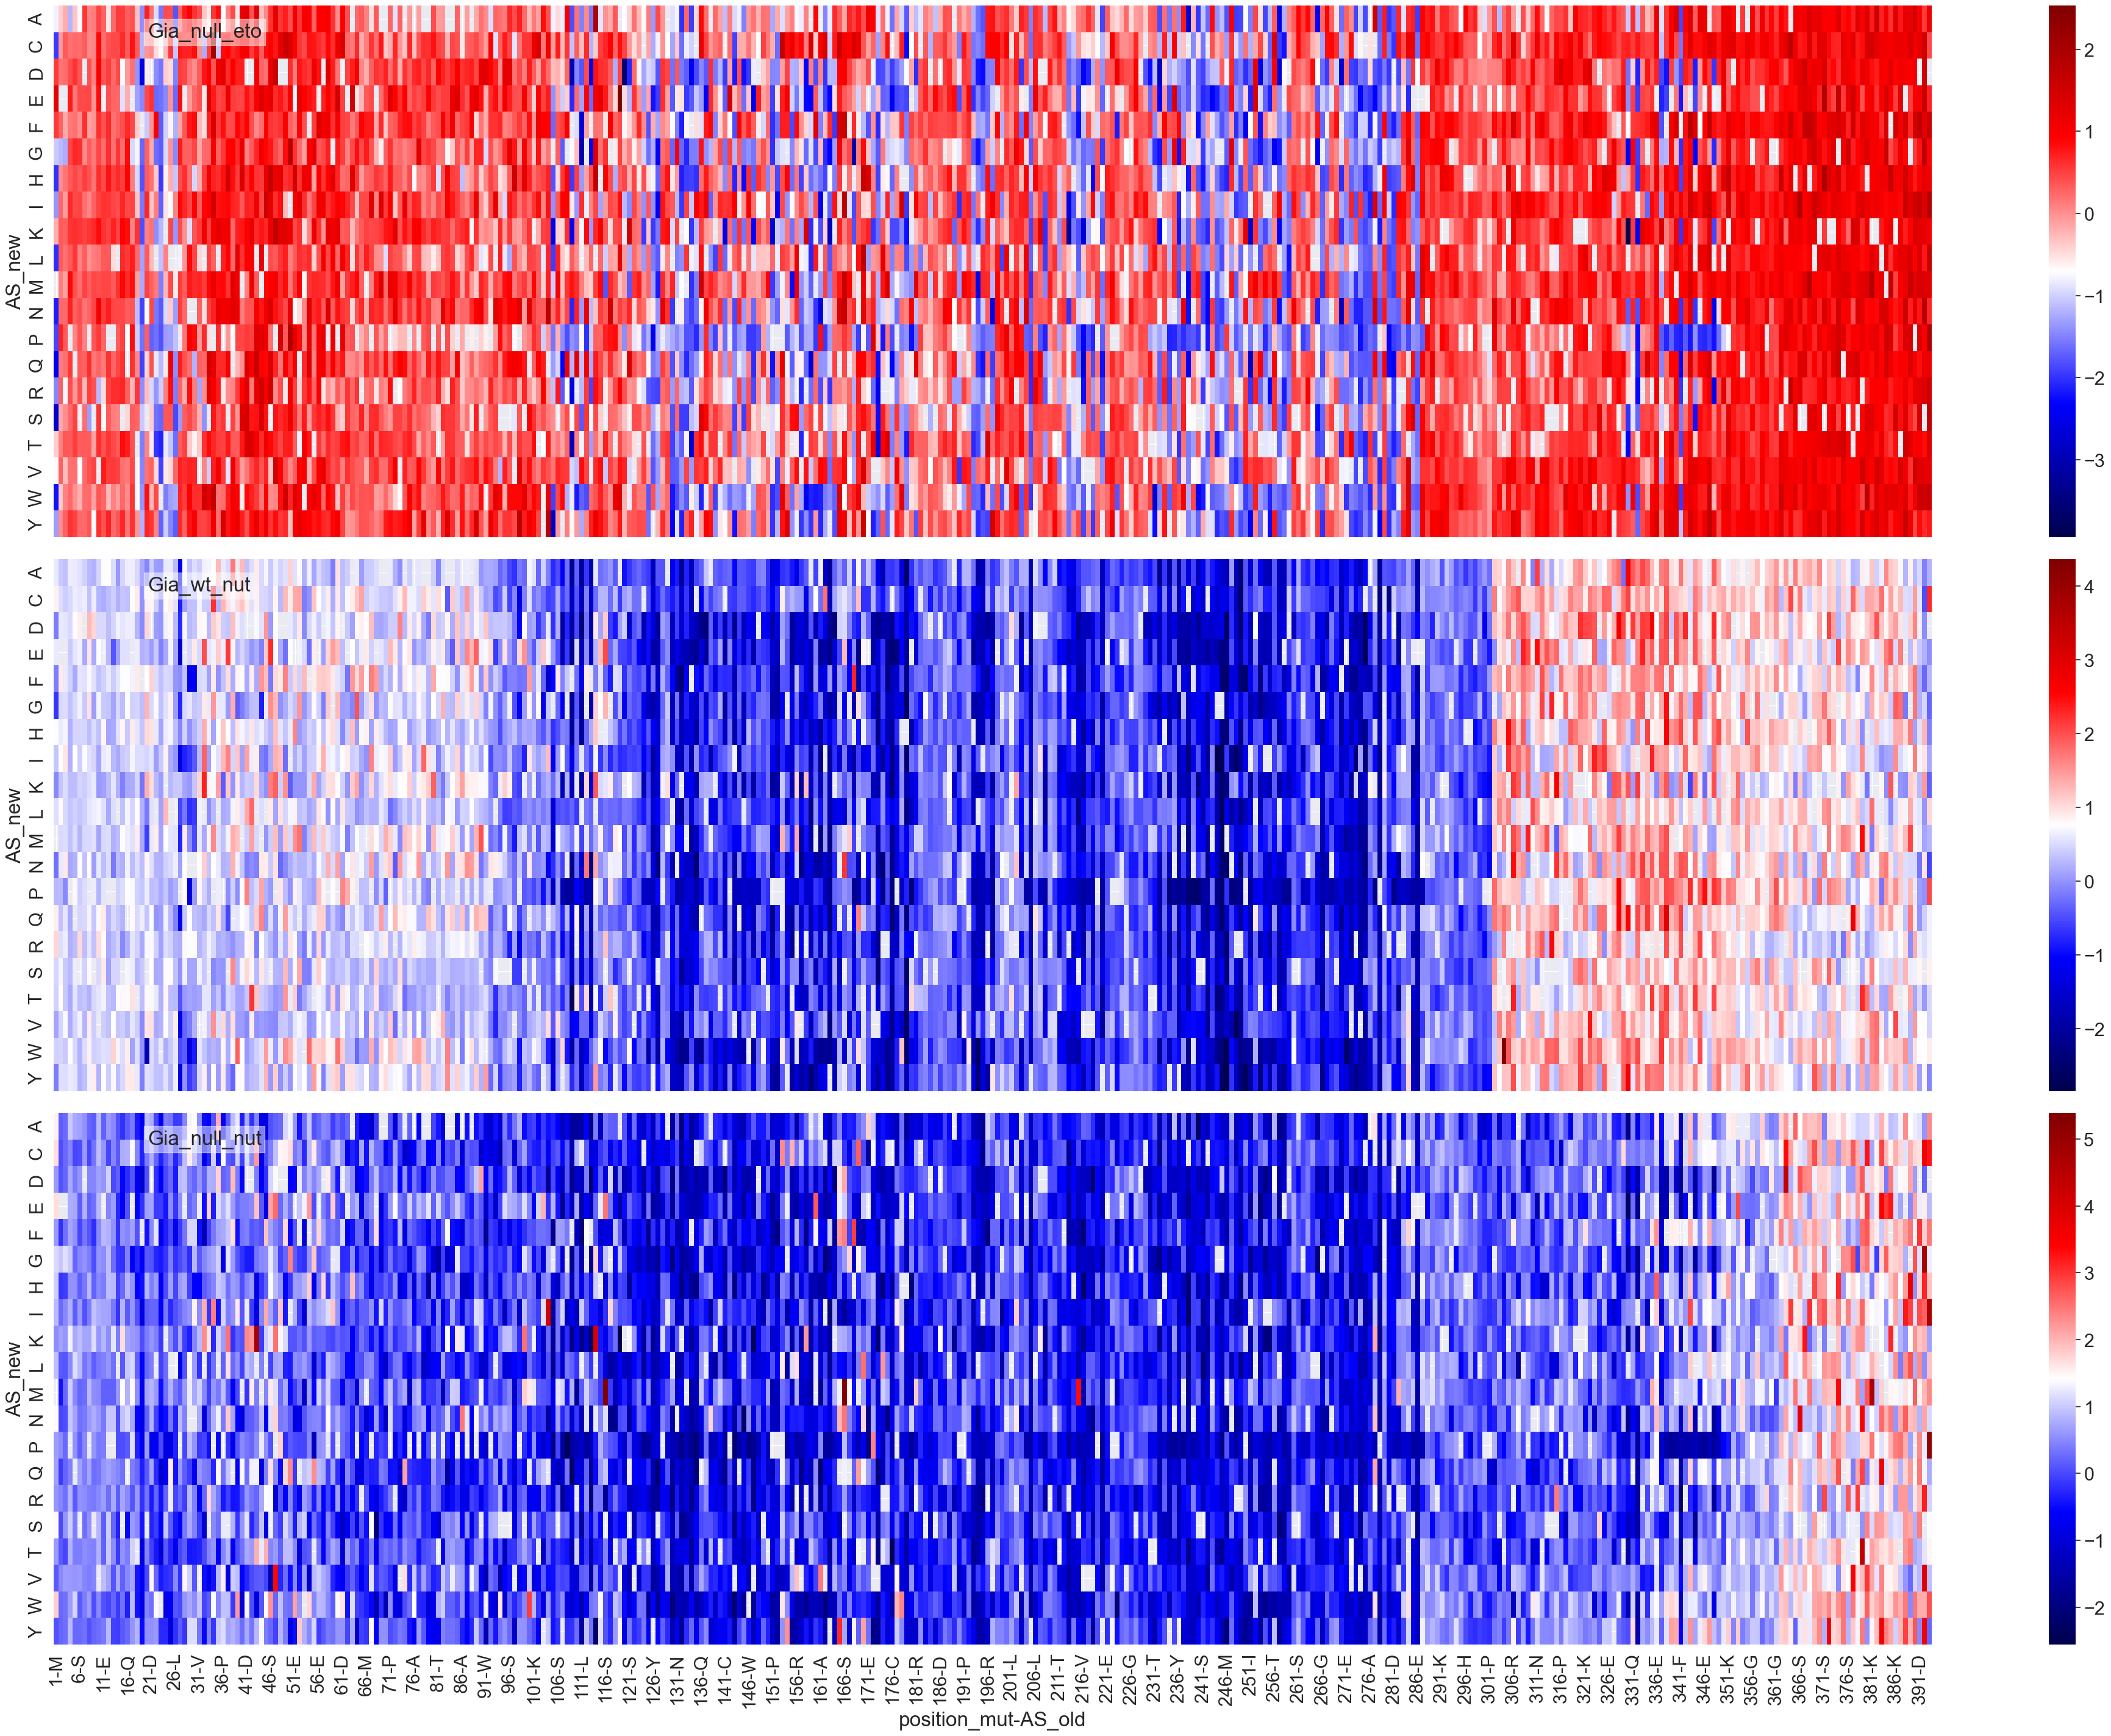

In [14]:
# Giacomelli Null Etoposide, Giacomelli Wildtype Nutlin, Giacomelli Null Nutlin
fun.mult_hmap(gia_null_eto, gia_wt_nut, gia_null_nut)

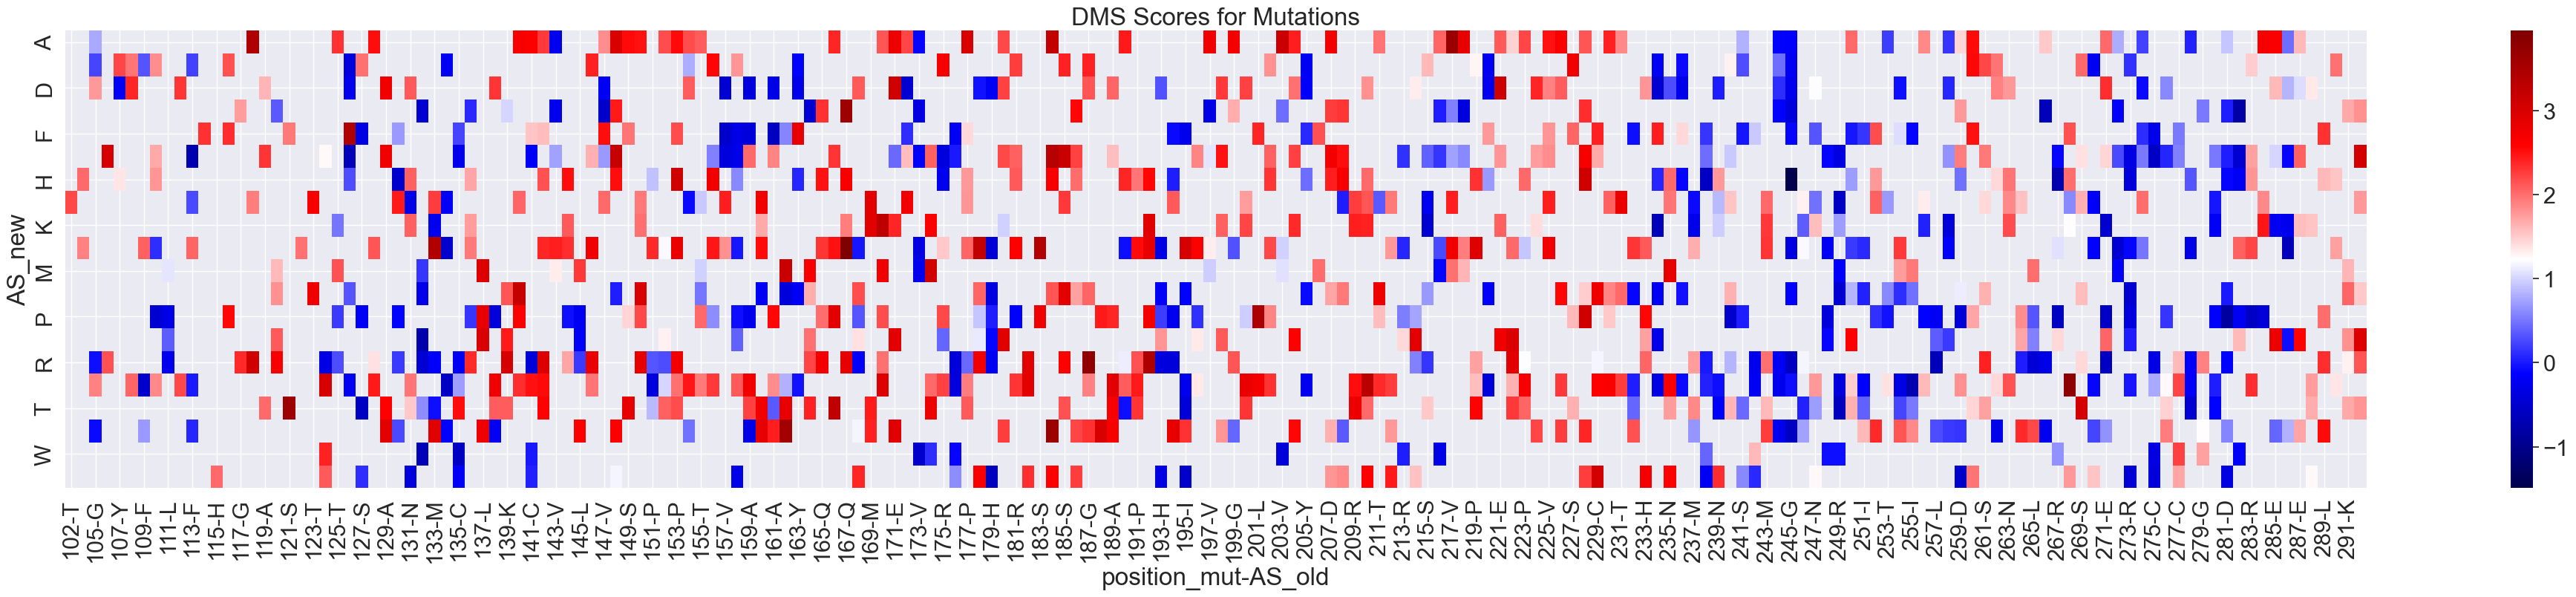

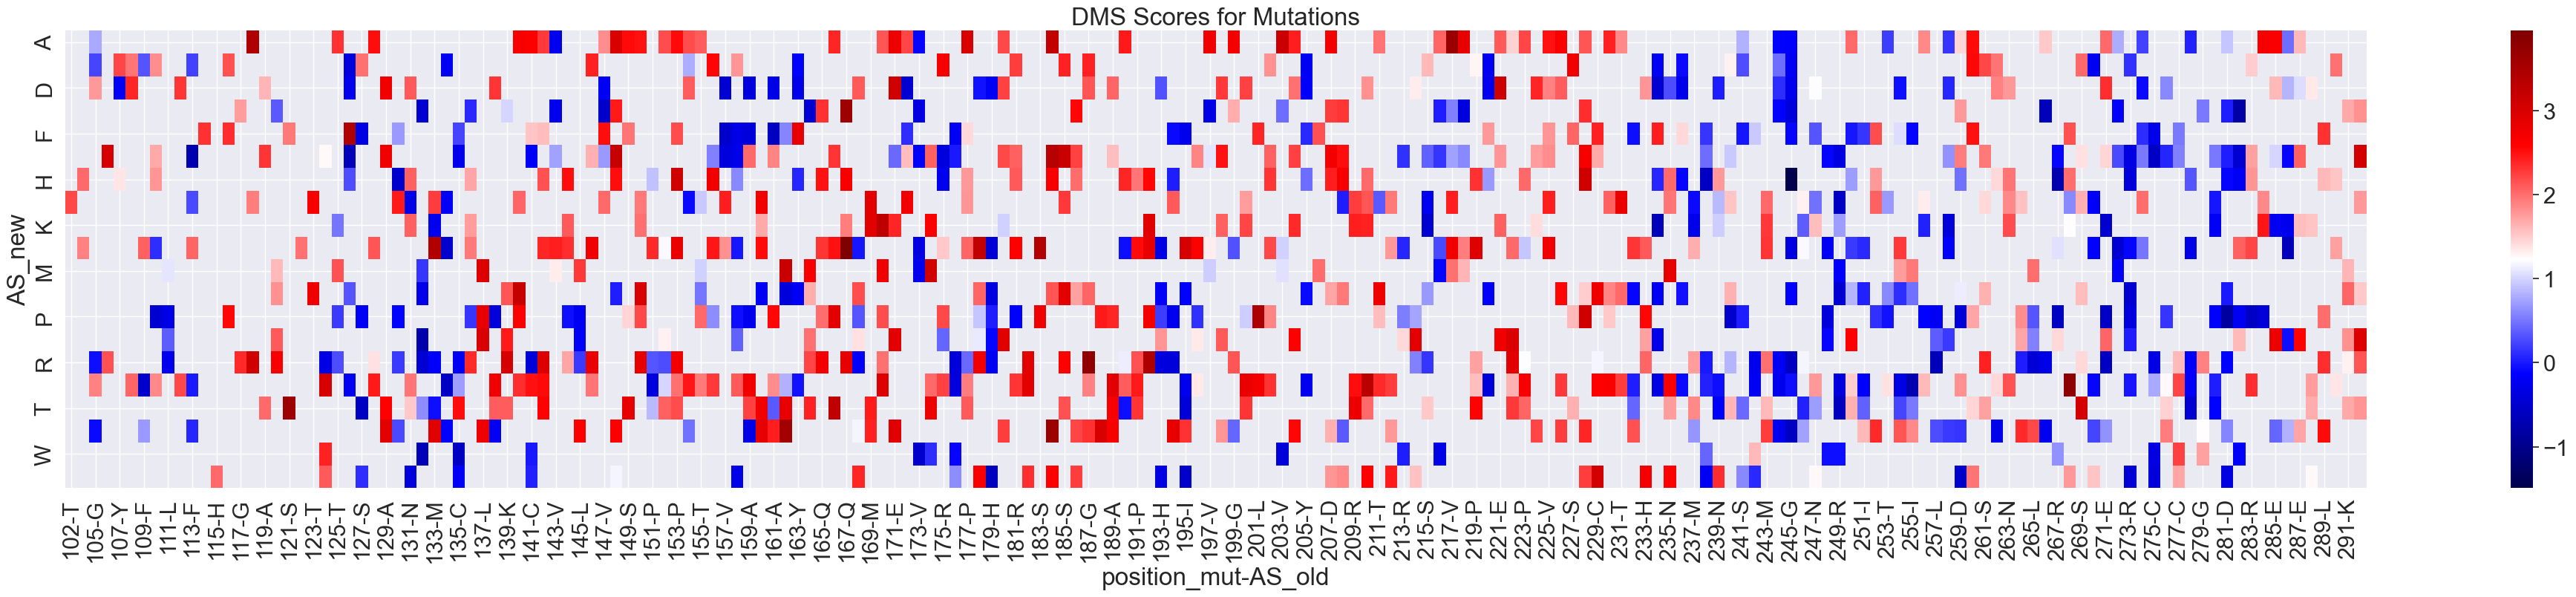

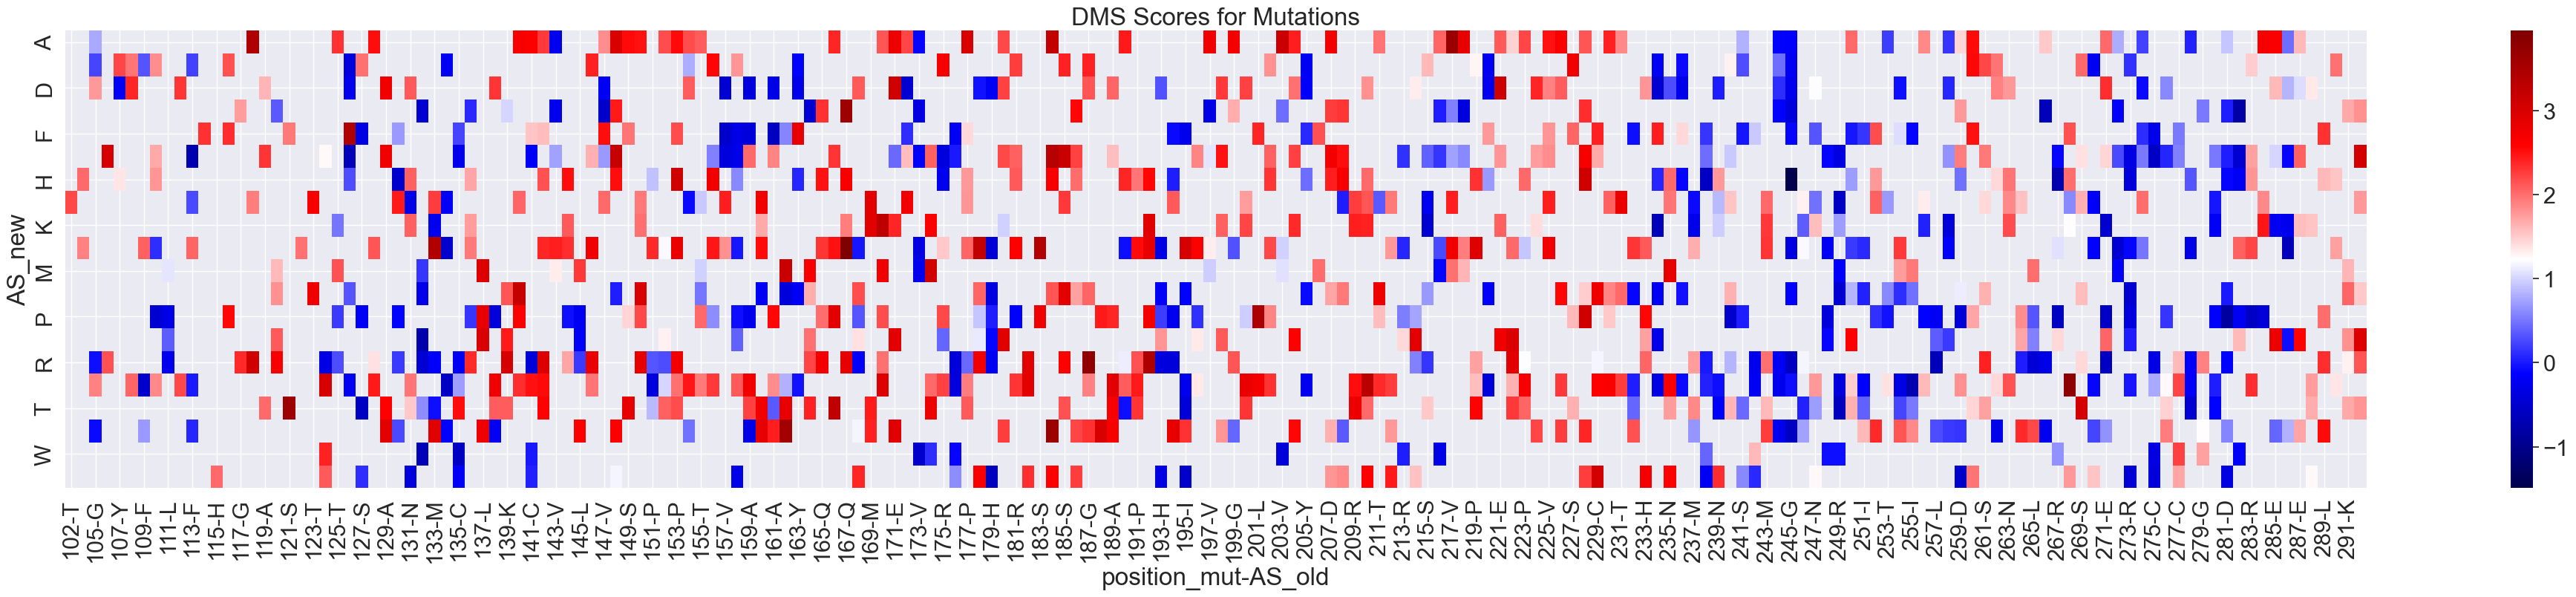

In [15]:
# Kotler
fun.hmap(doc.kot_hum_auf)

In [6]:
# These heatmaps show different trends:
# What we need to consider is that the Kotler dataset only covers a range of amino acids. From postion 102 to 292.                                      While the "Giacomelli Wildtype Nutlin" and "Giacomelli Null Nutlin" datasets exhibit some similarities in terms of trends and values, the same cannot be said when comparing them to the "Giacomelli Null Etoposide" dataset. This disparity is likely due to the use of different p53 activating agents, namely nutlin-3 and etoposide. One notable observation across all datasets is that amino acids in the range of approximately 100-300 generally display a negative effect caused by mutations. This could indicate a specific region that is evolutionary conserved and perfected. Additionally, the Kotler dataset exhibits a scarcity of values, which should be taken into consideration for future work.

In [7]:
# In addition to visually comparing the datasets, I wanted to investigate whether the datasets share positions in the amino acid sequence where the sum of all DMS scores is the lowest. This would indicate that these specific locations are particularly conserved.

In [8]:
# The 5 lowest values in the "Giacomelli null etoposide" dataset
dc.low_val(gia_null_eto, 5)

                           Sum
position_mut AS_old           
280          R      -33.450339
281          D      -33.446227
278          P      -32.028606
205          Y      -31.805002
275          C      -31.252744


In [9]:
# The 5 highest values in the "Giacomelli null etoposide" dataset
dc.high_val(gia_null_eto, 5)

                           Sum
position_mut AS_old           
392          S       23.640782
388          E       23.569597
393          D       23.458339
391          D       22.853878
374          G       22.718939


In [10]:
# The lowest Values (-> most affected by mutation) are found in:
doc.lowest_vals.head(20)

,Name of the Dataset,Location of lowest DMS_score sum,Sum,Original AA
0,Giacomelli Null Etoposide,280,-33.450339,R
1,Giacomelli NULL Nutlin,205,-27.798457,Y
2,Giacomelli WT Nutlin,245,-41.124490,G
3,Kotler,245,-4.352254,G


In [11]:
#In general, we can also take a look at a flexible number of the most negative locations and take a look at them next to eachother
doc.lowest_vals_gesammelt.head(5)

""


In [30]:
doc.liniengraph(doc.gia_null_eto_z_mmn_df_mean, doc.gia_null_nut_z_mmn_df_mean, doc.gia_wt_nut_z_mmn_df_mean, doc.kot_hum_z_mmn_df_mean)

AttributeError: module 'Documentation' has no attribute 'liniengraph'

IDEA: Maybe using T-Tests to show differences? In whatever context? -> idea inspired by project proposal from Malte and colleagues

## Data cleanup
#### Preparing the data to enable further anaylses

In [ ]:
# min max Normalisierung
norm_frame = dc.aufteilung_mut_pos(dc.norm(gia_null_eto))
print("Z-transfromation and Min Max normalisation of df")
fun.hmap(norm_frame)
print(f"Position of Low and High values of frame")
dc.min_max_val(norm_frame)

After we finished cleaning our data, we decided to transform the data into a new, more compact format.
In this new data frame the rows resemble the original AA sequence and the rows represent the exchange with a specific AA (e.g. A). The shown values are the DMS scores for the shown substitution. The NAs   shown for the exchanges where the old and new AA are the same, are changed to the value zero. With this transformed data set, further analyses are more easily to perform.

Max: Wir haben probiert Patientendaten zu bekommen, aber wir haben die nicht bekommen

## Data exploration
*Was sind die Ergebnisse, auf die ihr gekommen seid? Also implementierte Funktionen mit einfügen, um dann plotten zu können*

First, we wanted to get a feel for the mean scores for each substitution calculated from the whole length of the p53 protein.

In [ ]:
dc.rmv_na(de.mean_substitutions(norm_frame))

Then we calculated the differences of the AA to each other to look for optimal and suboptimal interchanges.

In [ ]:
# Distanzmatrix (DMS-Scores)

dist_p53 = de.dms_distance_matrix(norm_frame)

# IDEA: Compare Clustering with "dist_chem" ...
dist_p53

With this distance matrix for the whole length of our protein, we wanted to compare these findings with the distances based purely on the chemical properties.

In [ ]:
dist_chem = de.aa_distance_matrix(aa)

# IDEA: Compare Clustering with "dist_p53" ...
dist_chem

-> Gibt uns die Abstände der AS zueinander basierend auf den DMS-Scores bei Austausch von AS. Bin mir leider nicht sicher ob die Abstände der neuen oder alten AS zueinander berechnet werden. Und check auch nicht ganz wieso das nur mit der transponierten Matrix funktioniert

Anmerkung Enno, 29.6.: Frido, dann musst du das glaube ich nochmal schauen wie das genau geht :) Oder jemanden fragen...

## Domain comparison
#### Comparing Clusterings of substitutions in the context of specific protein domains

## Calculating severity scores
#### Matching DMS_scores with the mutation probability (only for single mutations)


In [ ]:
#Test for the aminoacid sequence obtained from the DNA sequence online
amino_acids_string = ses.translate_codons_to_string(ses.p53_codons_gia)

print(amino_acids_string)

# BLASTing shows: DNA sequence encodes the AA sequence which is the one the Kotler dataset uses as a reference! Position 72 is Proline, not Arginine.
#However: We want to use the Giacomelli dataset for this analysis, as the Kotler dataset does not contain mutational data for the whole sequence of p53. Therefore, we need to personally edit

In [ ]:
#editing AA 72 from Proline to Arginine by hand: no information available which DNA sequence was used by Giacomelli. Couldn't find information in paper...

#change P codon to R
p53_codons_kotler = [ses.rna_sequence[i:i+3] for i in range(0, len(ses.rna_sequence), 3)]
p53_codons_gia = p53_codons_kotler
p53_codons_gia[71] = "CGC"

#generate all AA reachable by single mutation for the whole length of p53
p53_var_frame_raw: pd.DataFrame = ses.translate_codons_df(ses.generate_codon_variations(ses.p53_codons_gia))

#cleaning single mutations of STOP codons
p53_var_frame = ses.clean_variation_matrix(p53_var_frame_raw)

In [ ]:
#prepare p53 dataset: might need transposing the df
df = dc.df_transform(norm_frame).T

#select all single mutations from DMS and calculate severity score
sel_mut: pd.DataFrame = ses.select_smut(df, p53_var_frame)
severity_score_p53: pd.DataFrame = ses.prob_smut(sel_mut,p53_var_frame)

sns.heatmap(dc.min_max_norm(severity_score_p53))
#hier sieht es so aus, als ob Arginin grundsätzlich die Fitness des Proteins negativ beeinflusst. Könnte man vllt untersuchen, ob das tatsächlich so ist und wie signifikant diese Feststellung ist.

In [ ]:
# next -> which probable variations did show an increased fitness score? Is there an AMS with increased DMS score, that
# is not probable by single base Mutation?

#doing analysis on other dataframes